## Laboratorio di Simulazione Numerica 

# ESERCITAZIONE 7 #

In questa esercitazione è stato sfruttato l'algoritmo di Metropolis per effettuare una simulazione di un insieme canonico caratterizzato da un modello di Lennard-Jones di Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle seguenti condizioni:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

### esercizio 7.1

In primo luogo sono state introdotte le _tail correction_ per il calcolo dell'energia potenziale per particella $U/N$ e della pressione $P$, correzioni dovute al considerare un raggio di cut-off entro il quale far valere le interazioni tra particelle all'interno della simulazione. Queste correzioni sono state stimate per $r > rcut$ assumendo $g(r)\approx1$:
1. $\bigl\langle V lj \bigr\rangle tail\cong2\pi\rho\int_{rcut}^\infty drr^24\epsilon[({\sigma \over r})^{12}-({\sigma \over r})^{6}]=8\pi\rho({1 \over 9{rcut}^9}-{1 \over 3{rcut}^3})$
2. ${\bigl\langle w lj \bigr\rangle tail \over 3N\epsilon}\cong{2 \over 3}\pi\rho\int_{rcut}^\infty drr^2{48}[(\sigma/r)^{12}-{1 \over 2}(\sigma/r)^{6}]=32\pi\rho({1 \over 9{rcut}^9}-{1 \over 6{rcut}^3})$

### esercizio 7.2

scopo del secondo esercizio era trovare la lunghezza ottimale dei blocchi per effettuare al meglio le simulazioni dell'Argon con il data-blocking. Per prima cosa è stato necessario equilibrare il sistema, di seguito sono riportate le simulazioni effettuate con i valori istantanei di $U/N$ in funzione dello step

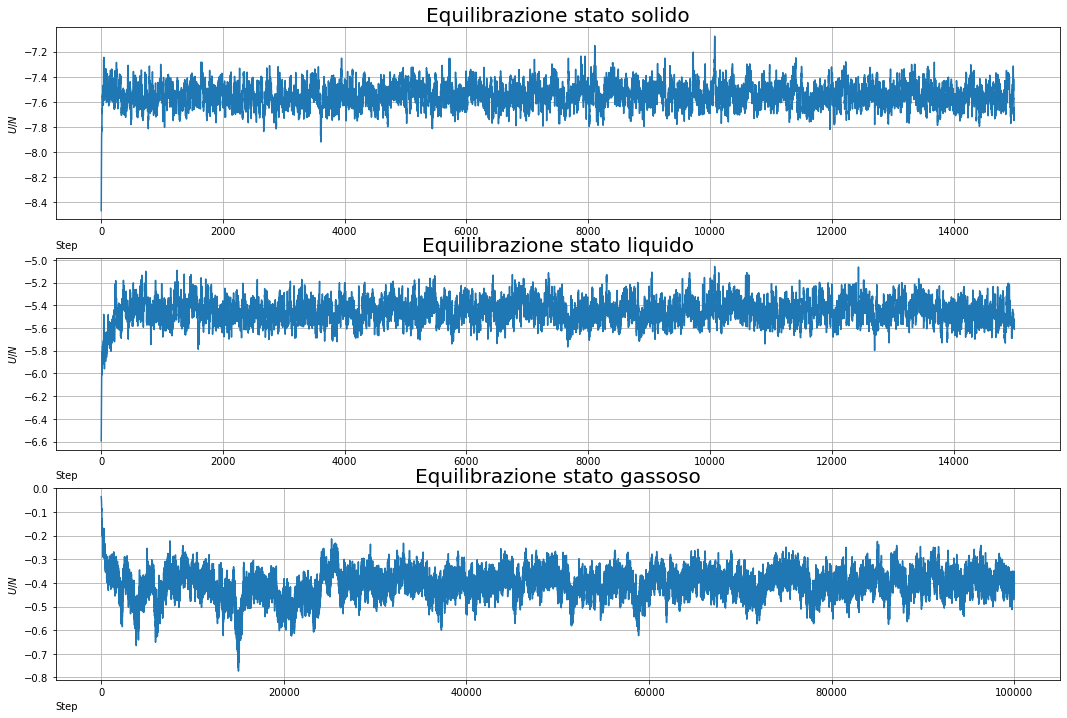

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#EQUILIBRAZIONE SOLIDO
f = plt.figure(figsize=(18,12))
em5 = np.loadtxt("epot_equ_SOL.dat", usecols=(1), unpack='true')
x = np.arange(em5.size)
plt = f.add_subplot(311)
plt.plot(x, em5)
plt.set_title('Equilibrazione stato solido', fontsize=20)
plt.set_ylabel('$U/N$')
plt.set_xlabel('Step', loc="left")
plt.grid(True)

#EQUILIBRAZIONE LIQUIDO
em5 = np.loadtxt("epot_equ_LIQ.dat", usecols=(1), unpack='true')
x = np.arange(em5.size)
plt = f.add_subplot(312)
plt.plot(x, em5)
plt.set_title('Equilibrazione stato liquido', fontsize=20)
plt.set_ylabel('$U/N$')
plt.set_xlabel('Step', loc="left")
plt.grid(True)

#EQUILIBRAZIONE GAS
em5 = np.loadtxt("epot_equ_GAS.dat", usecols=(1), unpack='true')
x = np.arange(em5.size)
plt = f.add_subplot(313)
plt.plot(x, em5)
plt.set_title('Equilibrazione stato gassoso', fontsize=20)
plt.set_ylabel('$U/N$')
plt.set_xlabel('Step', loc="left")
plt.grid(True)

Si può notare come per lo stato solido bastano pochi passi per equilibrarsi (1000), per il liquido ne servono di più ma sempre nell'ordine di grandezza delle migliaia(2000), mentre per il gas ne servono molti di più, risultando equilibrato dopo 30000 step.

Effettuata l'equilibrazione si procede con una simulazione per trovare per ogni fase i valori istantanei di $U/N$ per poi analizzarli con due script python, il primo che calcola una funzione _autocorrelazione_, indica il livello di correlazione presente da due variabili separate da $n$ passi, e l'altro che calcola l'andamento dell'errore e la sua incertezza in funzione del numero di step per blocco.

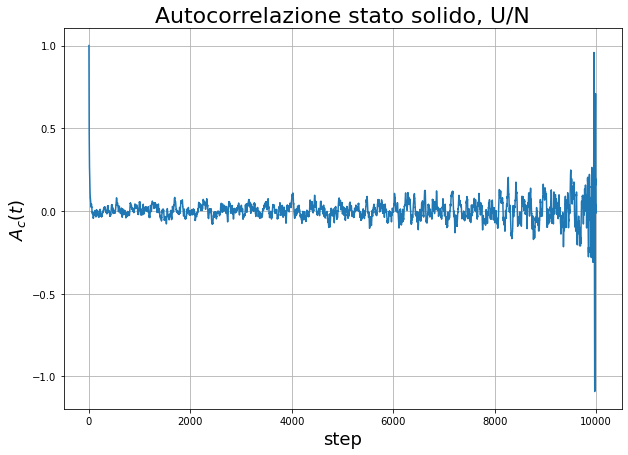

In [44]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def chi(t, tmax, z):
    sum1 = 0
    sum2 = 0
    sum3 = 0
    sum4 = 0
    sum5 = 0
    delta = tmax - t
    for i in range(int(delta)):
        sum1 += z[i]*z[i+int(t)]
        sum2 += z[i]
        sum3 += z[i+int(t)]
    for i in range(int(tmax)):
        sum4 += z[i]*z[i]
        sum5 += z[i]
    return (sum1/delta - (sum2/delta)*(sum3/delta))/((sum4/tmax) - (sum5/tmax)**2)

tvector, z = np.loadtxt("epot_insta_SOL.dat", usecols=(0, 1), unpack='true') #, max_rows=10000
tvector=tvector-1
tmax = 10000
#print (tmax)
y=np.zeros(10000)
x=np.zeros(10000)
for i in range(int(tmax)): ##for i in range(0,10000): for i in range(int(tmax)):
    y[i] = chi(tvector[i], tmax, z)
    x[i] = i+1
    #if(i%1000 == 0):
    #   print(i)
plt.figure(figsize=(10, 7))

plt.title('Autocorrelazione stato solido, U/N', fontsize=22)
plt.plot(x, y) #[0:5000]
plt.xlabel('step', fontsize=18)
plt.ylabel('$A_c(t)$', fontsize=18)
plt.grid(True)

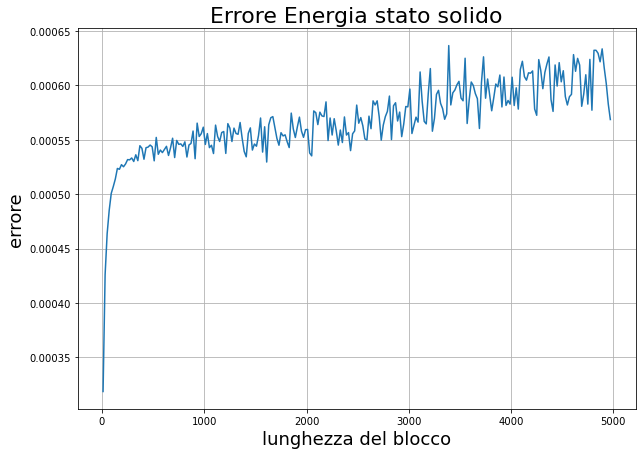

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np




def errore(ave, ave2, n):
    if (n == 0):
        return 0;
    return ((ave2 - ave*ave)/n)**(1/2)


def err_blk(z, L, M):
    sum1 = 0
    ave1 = 0
    ave2 = 0
    N = int(M/L)
    k = 0
    for i in range(N):
        sum1 = 0
        for j in range(L):
            sum1 = sum1 + z[k]
            k = k +1
        ave1 = ave1 + sum1/L
        ave2 = ave2 + (sum1/L)**2
        
    err = errore(ave1/N, ave2/N, N)
    return err

tvector, z = np.loadtxt("epot_insta_SOL.dat", usecols=(0, 1), unpack='true')
M = tvector[tvector.size-1]       
#print (M)
deltaL = 20
L = 10
Lmax = 5000
dim = int((Lmax - L)/deltaL)
y=np.zeros(dim)
x=np.zeros(dim)

for i in range(dim):
    y[i] = err_blk(z, L, M)
    x[i] = L
    L = L+deltaL

plt.figure(figsize=(10, 7))

plt.title('Errore Energia stato solido', fontsize=22)

plt.xlabel('lunghezza del blocco', fontsize=18)
plt.ylabel('errore', fontsize=18)
        
plt.plot(x, y)
plt.grid(True)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


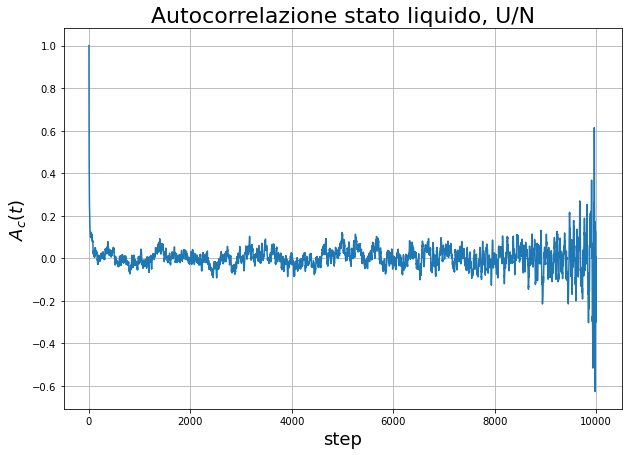

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def chi(t, tmax, z):
    sum1 = 0
    sum2 = 0
    sum3 = 0
    sum4 = 0
    sum5 = 0
    delta = tmax - t
    for i in range(int(delta)):
        sum1 += z[i]*z[i+int(t)]
        sum2 += z[i]
        sum3 += z[i+int(t)]
    for i in range(int(tmax)):
        sum4 += z[i]*z[i]
        sum5 += z[i]
    return (sum1/delta - (sum2/delta)*(sum3/delta))/((sum4/tmax) - (sum5/tmax)**2)

tvector, z = np.loadtxt("epot_insta_LIQ.dat", usecols=(0, 1), unpack='true') #, max_rows=10000
tvector=tvector-1
tmax = 10000
#print (tmax)
y=np.zeros(10000)
x=np.zeros(10000)
for i in range(int(tmax)): ##for i in range(0,10000): for i in range(int(tmax)):
    y[i] = chi(tvector[i], tmax, z)
    x[i] = i+1
    if(i%1000 == 0):
        print(i)
plt.figure(figsize=(10, 7))

plt.title('Autocorrelazione stato liquido, U/N', fontsize=22)
plt.plot(x, y) #[0:5000]
plt.xlabel('step', fontsize=18)
plt.ylabel('$A_c(t)$', fontsize=18)
plt.grid(True)

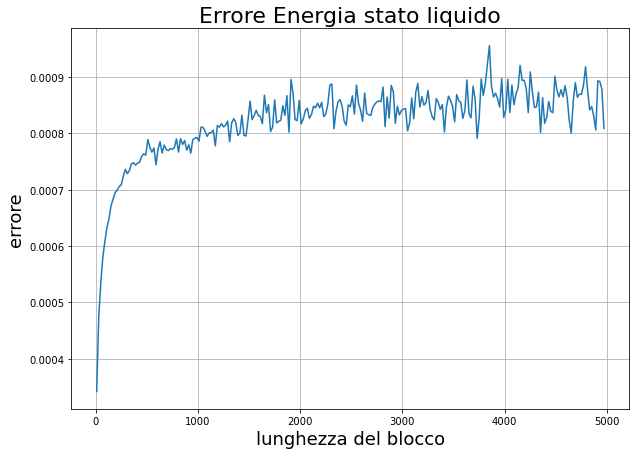

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np




def errore(ave, ave2, n):
    if (n == 0):
        return 0;
    return ((ave2 - ave*ave)/n)**(1/2)


def err_blk(z, L, M):
    sum1 = 0
    ave1 = 0
    ave2 = 0
    N = int(M/L)
    k = 0
    for i in range(N):
        sum1 = 0
        for j in range(L):
            sum1 = sum1 + z[k]
            k = k +1
        ave1 = ave1 + sum1/L
        ave2 = ave2 + (sum1/L)**2
        
    err = errore(ave1/N, ave2/N, N)
    return err

tvector, z = np.loadtxt("epot_insta_LIQ.dat", usecols=(0, 1), unpack='true')
M = tvector[tvector.size-1]       
#print (M)
deltaL = 20
L = 10
Lmax = 5000
dim = int((Lmax - L)/deltaL)
y=np.zeros(dim)
x=np.zeros(dim)

for i in range(dim):
    y[i] = err_blk(z, L, M)
    x[i] = L
    L = L+deltaL

plt.figure(figsize=(10, 7))

plt.title('Errore Energia stato liquido', fontsize=22)

plt.xlabel('lunghezza del blocco', fontsize=18)
plt.ylabel('errore', fontsize=18)
        
plt.plot(x, y)
plt.grid(True)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


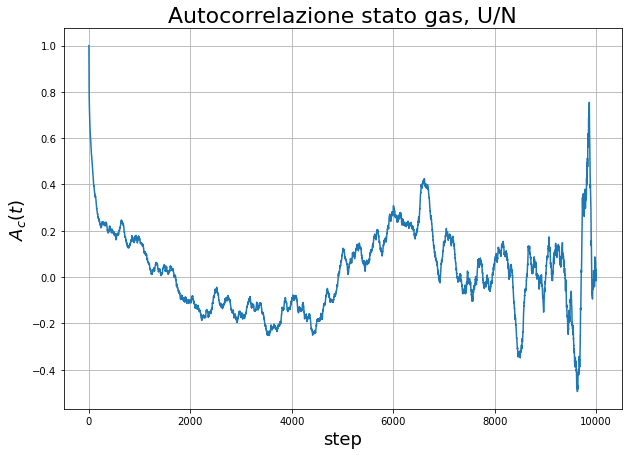

In [55]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def chi(t, tmax, z):
    sum1 = 0
    sum2 = 0
    sum3 = 0
    sum4 = 0
    sum5 = 0
    delta = tmax - t
    for i in range(int(delta)):
        sum1 += z[i]*z[i+int(t)]
        sum2 += z[i]
        sum3 += z[i+int(t)]
    for i in range(int(tmax)):
        sum4 += z[i]*z[i]
        sum5 += z[i]
    return (sum1/delta - (sum2/delta)*(sum3/delta))/((sum4/tmax) - (sum5/tmax)**2)

tvector, z = np.loadtxt("epot_insta_GAS.dat", usecols=(0, 1), unpack='true') #, max_rows=10000
tvector=tvector-1
tmax = 10000
#print (tmax)
y=np.zeros(tmax)
x=np.zeros(tmax)
for i in range(int(tmax)): ##for i in range(0,10000): for i in range(int(tmax)):
    y[i] = chi(tvector[i], tmax, z)
    x[i] = i+1
    if(i%1000 == 0):
        print(i)
plt.figure(figsize=(10, 7))

plt.title('Autocorrelazione stato gas, U/N', fontsize=22)
plt.plot(x, y) #[0:5000]
plt.xlabel('step', fontsize=18)
plt.ylabel('$A_c(t)$', fontsize=18)
plt.grid(True)

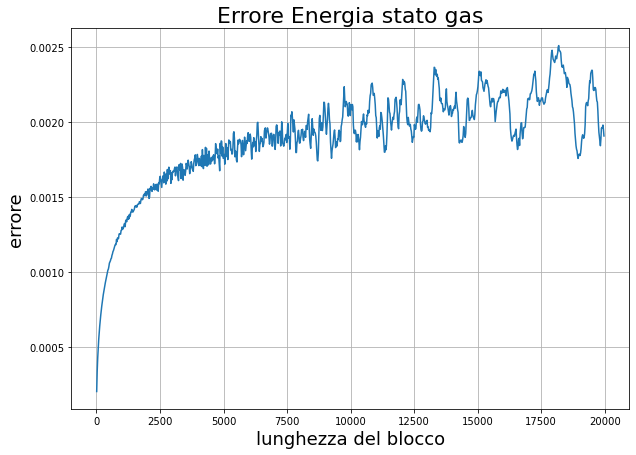

In [57]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np




def errore(ave, ave2, n):
    if (n == 0):
        return 0;
    return ((ave2 - ave*ave)/n)**(1/2)


def err_blk(z, L, M):
    sum1 = 0
    ave1 = 0
    ave2 = 0
    N = int(M/L)
    k = 0
    for i in range(N):
        sum1 = 0
        for j in range(L):
            sum1 = sum1 + z[k]
            k = k +1
        ave1 = ave1 + sum1/L
        ave2 = ave2 + (sum1/L)**2
        
    err = errore(ave1/N, ave2/N, N)
    return err

tvector, z = np.loadtxt("epot_insta_GAS.dat", usecols=(0, 1), unpack='true')
M = tvector[tvector.size-1]       
#print (M)
deltaL = 20
L = 10
Lmax = 20000
dim = int((Lmax - L)/deltaL)
y=np.zeros(dim)
x=np.zeros(dim)

for i in range(dim):
    y[i] = err_blk(z, L, M)
    x[i] = L
    L = L+deltaL

plt.figure(figsize=(10, 7))

plt.title('Errore Energia stato gas', fontsize=22)

plt.xlabel('lunghezza del blocco', fontsize=18)
plt.ylabel('errore', fontsize=18)
        
plt.plot(x, y)
plt.grid(True)

* Nelle funzioni di autocorrelazione: si può notare come ben sotto i 5000 step i dati risultino scorrelati per quanto riguarda il solido e il liquido. Mentre per il gas ciò non accade.
* Nell'andamento dell'errore: si può notare che per pochi step per blocco ci sia una sottostima dell'incertezza, la quale tende a crescere e stabilizzarsi intorno ai 5000 step per blocco per il solido, 2000 per il liquido e 11000 per il gas.


### esercizio 7.3

In questo esercizio è stato implementato nel codice comune sia per simulazione con _Dinamica Molecolare-NVE_ che con _Montecarlo-NVT_ il calcolo della funzione distribuzione radiale $g(r)$, funzione della distanza radiale tra le particelle con $r\in[0;{L\over2}]$. A questo scopo abbiamo l'intervallo in 100 sottointervalli, ciascuno dotato di una valore annesso. Valutando poi la distanza tra tutte le coppie, abbiamo incrementato di 2 (essendo una doppia somma) il valore dell'intervallo in cui cadeva la distanza trovata. Ciclando su tutte le coppie e tutti gli step abbiamo ottenuto un istogramma che rappresentasse la $g(r)$. Abbiamo infine opportunamente normalizzato l'istogramma ottenuto.

### esercizio 7.4

Dopo aver migliorato e completato il codice con tutto ciò che è necessario allo svolgimento descritto nell'introduzione di questa esercitazione si inizia con le simulazioni desiderate.

Oltre il calcolo di $U/N$ e $P$ è stato effettuato anche il calcolo di $g(r)$. Quest'ultimo è stato effettuato sia nel caso dell'insieme canonico _Montecarlo-NVT_ sia nell'insieme del microcanonico _Molecular Dinamics-NVE_ per poter confrontare i risultati. Per il caso _MD-NVE_ la simulazione è stata ottenuta con un'equilibrazione trovata nell'esercitazione precedente numero 4.

Per queste simulazioni sono stati utilizzati 100 blocchi da 5000 step ciascuno per un totale di $M=5\times10^5$

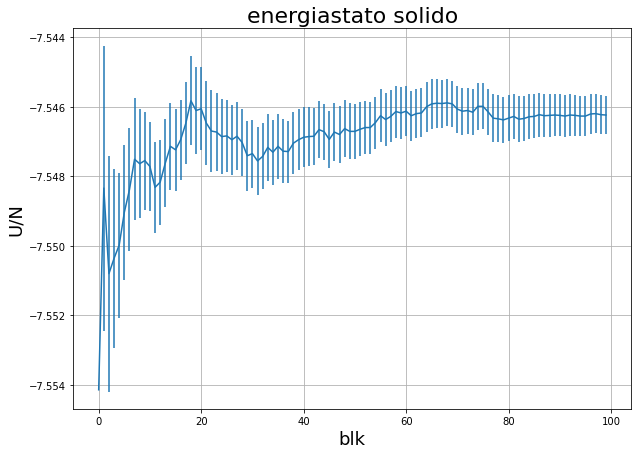

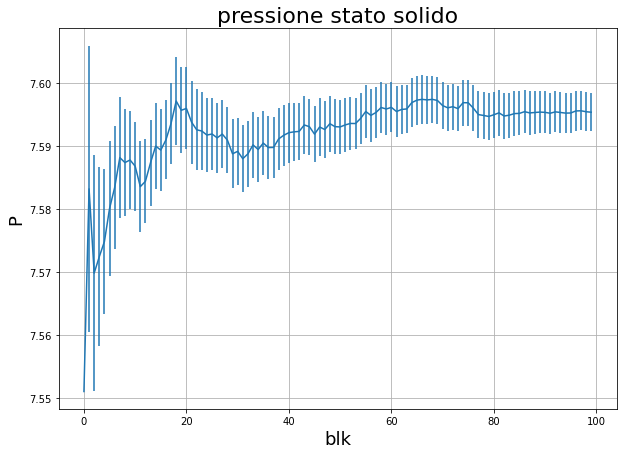

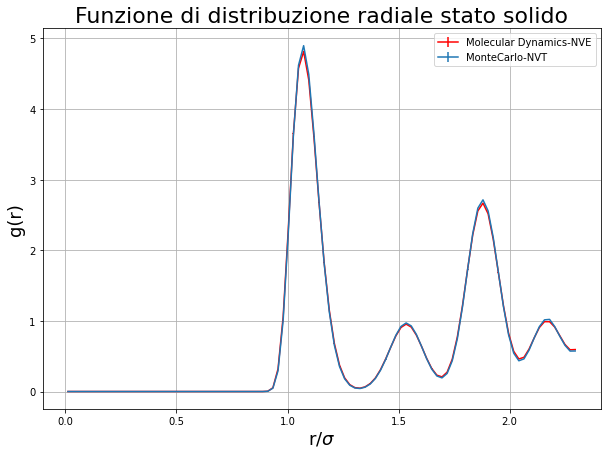

In [14]:
#SOLIDO

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


f, error = np.loadtxt("output_epot_SOL.0", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(10,7))
plt.errorbar(x,f,error)
plt.xlabel('blk', fontsize=18)
plt.ylabel('U/N', fontsize=18)
plt.title("energiastato solido", fontsize = 22)
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_pres_SOL.0", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(10,7))
plt.errorbar(x,f,error)
plt.xlabel('blk', fontsize=18)
plt.ylabel('P', fontsize=18)
plt.title("pressione stato solido", fontsize = 22)
plt.grid(True)
plt.show()


# g(r)
x, f, error = np.loadtxt("output_gave_SOL.0", usecols=(0,1,2), unpack='true', delimiter='\t')
xMD, fMD, errorMD = np.loadtxt("output_gave_SOL_MD.0", usecols=(0,1,2), unpack='true', delimiter='\t')
plt.figure(figsize=(10,7))
plt.errorbar(xMD,fMD,errorMD, label="Molecular Dynamics-NVE", color='red')
plt.errorbar(x,f,error, label="MonteCarlo-NVT")
plt.xlabel('r/$\sigma$', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.title("Funzione di distribuzione radiale stato solido", fontsize = 22)
plt.legend(loc ="best")
plt.grid(True)
plt.show()


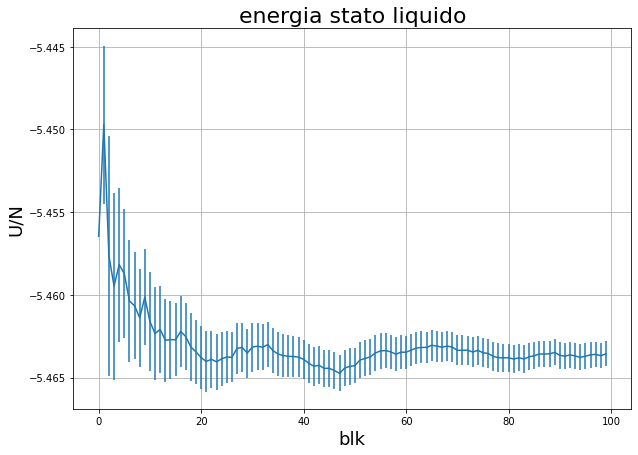

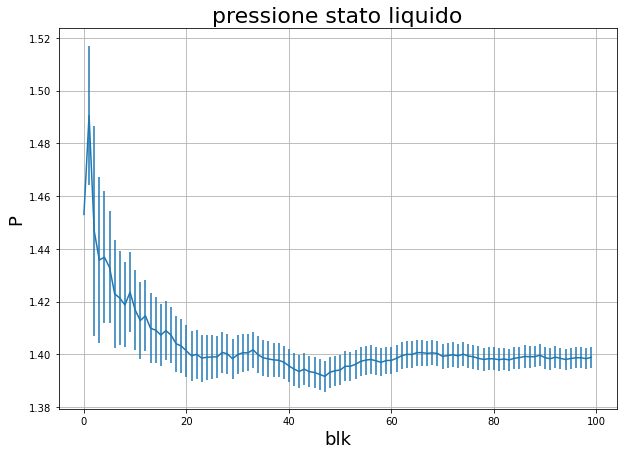

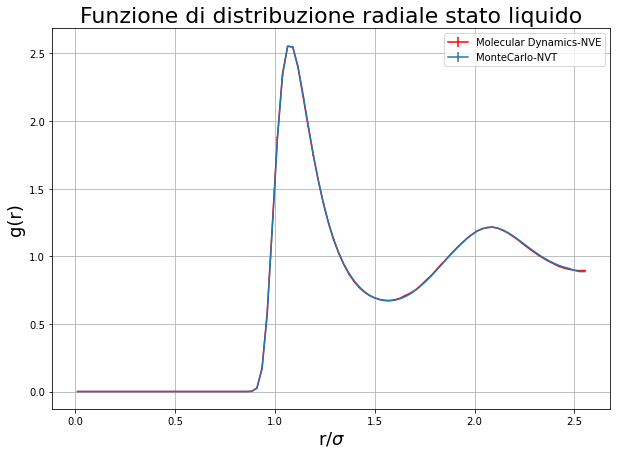

In [19]:
#LIQUIDO

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


f, error = np.loadtxt("output_epot_LIQ.0", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(10,7))
plt.errorbar(x,f,error)
plt.xlabel('blk', fontsize=18)
plt.ylabel('U/N', fontsize=18)
plt.title("energia stato liquido", fontsize = 22)
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_pres_LIQ.0", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(10,7))
plt.errorbar(x,f,error)
plt.xlabel('blk', fontsize=18)
plt.ylabel('P', fontsize=18)
plt.title("pressione stato liquido", fontsize = 22)
plt.grid(True)
plt.show()


# g(r)
x, f, error = np.loadtxt("output_gave_LIQ.0", usecols=(0,1,2), unpack='true', delimiter='\t')
xMD, fMD, errorMD = np.loadtxt("output_gave_LIQ_MD.0", usecols=(0,1,2), unpack='true', delimiter='\t')
plt.figure(figsize=(10,7))
plt.errorbar(xMD,fMD,errorMD, label="Molecular Dynamics-NVE", color='red')
plt.errorbar(x,f,error, label="MonteCarlo-NVT")
plt.xlabel('r/$\sigma$', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.title("Funzione di distribuzione radiale stato liquido", fontsize = 22)
plt.legend(loc ="best")
plt.grid(True)
plt.show()


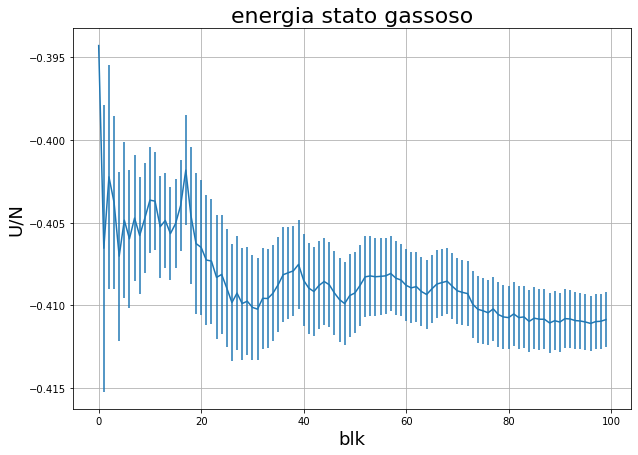

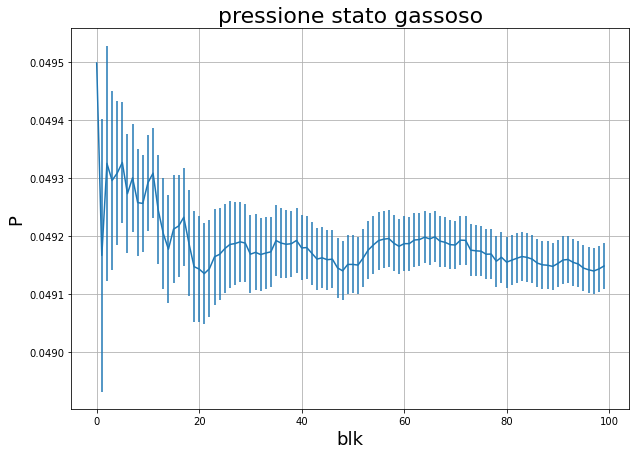

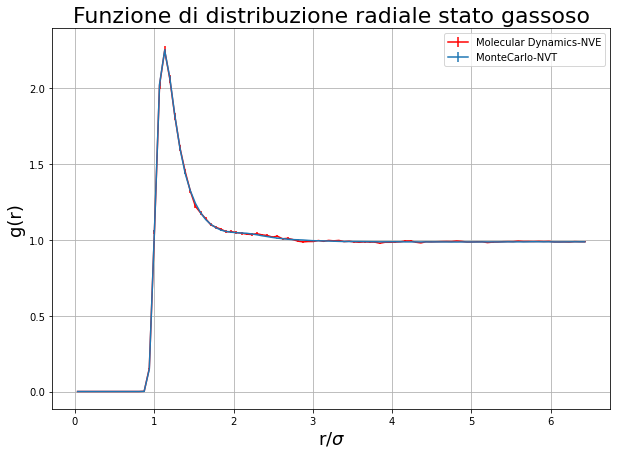

In [15]:
#GAS

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


f, error = np.loadtxt("output_epot_GAS.0", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(10,7))
plt.errorbar(x,f,error)
plt.xlabel('blk', fontsize=18)
plt.ylabel('U/N', fontsize=18)
plt.title("energia stato gassoso", fontsize = 22)
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_pres_GAS.0", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(10,7))
plt.errorbar(x,f,error)
plt.xlabel('blk', fontsize=18)
plt.ylabel('P', fontsize=18)
plt.title("pressione stato gassoso", fontsize = 22)
plt.grid(True)
plt.show()


# g(r)
x, f, error = np.loadtxt("output_gave_GAS.0", usecols=(0,1,2), unpack='true', delimiter='\t')
xMD, fMD, errorMD = np.loadtxt("output_gave_GAS_MD.0", usecols=(0,1,2), unpack='true', delimiter='\t')
plt.figure(figsize=(10,7))
plt.errorbar(xMD,fMD,errorMD, label="Molecular Dynamics-NVE", color='red')
plt.errorbar(x,f,error, label="MonteCarlo-NVT")
plt.xlabel('r/$\sigma$', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.title("Funzione di distribuzione radiale stato gassoso", fontsize = 22)
plt.legend(loc ="best")
plt.grid(True)
plt.show()


tramite la funzione di distribuzione radiale si può notare come i due ensemble statistici siano perfettamente compatibili, verificando la portata della meccanica statistica.